In [1]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(234)
tf.random.set_seed(234)

In [2]:
inf_data = pd.read_csv('Final_Dataset.csv')

In [3]:
inf_data.head()

,DATE,CPI,M2,UNRATE,DSPI,PCE,FEDFUNDS,INDPRO,M1SL
0,01-01-1990,132.1,3166.8,5.4,4208.4,3730.7,8.23,61.6440,795.4
1,01-02-1990,132.7,3179.2,5.3,4236.3,3728.2,8.24,62.2108,798.1
2,01-03-1990,133.5,3190.1,5.2,4254.0,3754.9,8.28,62.5068,801.5
3,01-04-1990,134.0,3201.6,5.4,4290.8,3770.0,8.26,62.3597,806.1
4,01-05-1990,134.4,3200.6,5.4,4296.0,3775.8,8.18,62.5474,804.2


In [4]:
inf_data.shape

(406, 9)

In [5]:


inf_data.dropna(inplace=True)
inf_data.head(5)



,DATE,CPI,M2,UNRATE,DSPI,PCE,FEDFUNDS,INDPRO,M1SL
0,01-01-1990,132.1,3166.8,5.4,4208.4,3730.7,8.23,61.6440,795.4
1,01-02-1990,132.7,3179.2,5.3,4236.3,3728.2,8.24,62.2108,798.1
2,01-03-1990,133.5,3190.1,5.2,4254.0,3754.9,8.28,62.5068,801.5
3,01-04-1990,134.0,3201.6,5.4,4290.8,3770.0,8.26,62.3597,806.1
4,01-05-1990,134.4,3200.6,5.4,4296.0,3775.8,8.18,62.5474,804.2


In [11]:
inf_data.dtypes

DATE        datetime64[ns]
CPI                float64
M2                 float64
UNRATE             float64
DSPI               float64
PCE                float64
FEDFUNDS           float64
INDPRO             float64
M1SL               float64
dtype: object

In [7]:
inf_data.DATE = pd.to_datetime(inf_data.DATE)

In [8]:
inf_data['DATE'].nunique()

361

In [9]:
inf_df = inf_data.copy()

In [10]:
inf_df.columns

Index(['DATE', 'CPI', 'M2', 'UNRATE', 'DSPI', 'PCE', 'FEDFUNDS', 'INDPRO',
       'M1SL'],
      dtype='object')

In [34]:
inf_df['cpi_pct_mom'] = round((inf_data['CPI'].pct_change().fillna(0)) * 100, 2)
inf_df['cpi_pct_yoy'] = round((inf_data['CPI'].pct_change(12).fillna(0)) * 100, 2)
inf_df['cpi_pct_qoq'] = round((inf_data['CPI'].pct_change(3).fillna(0)) * 100, 2)

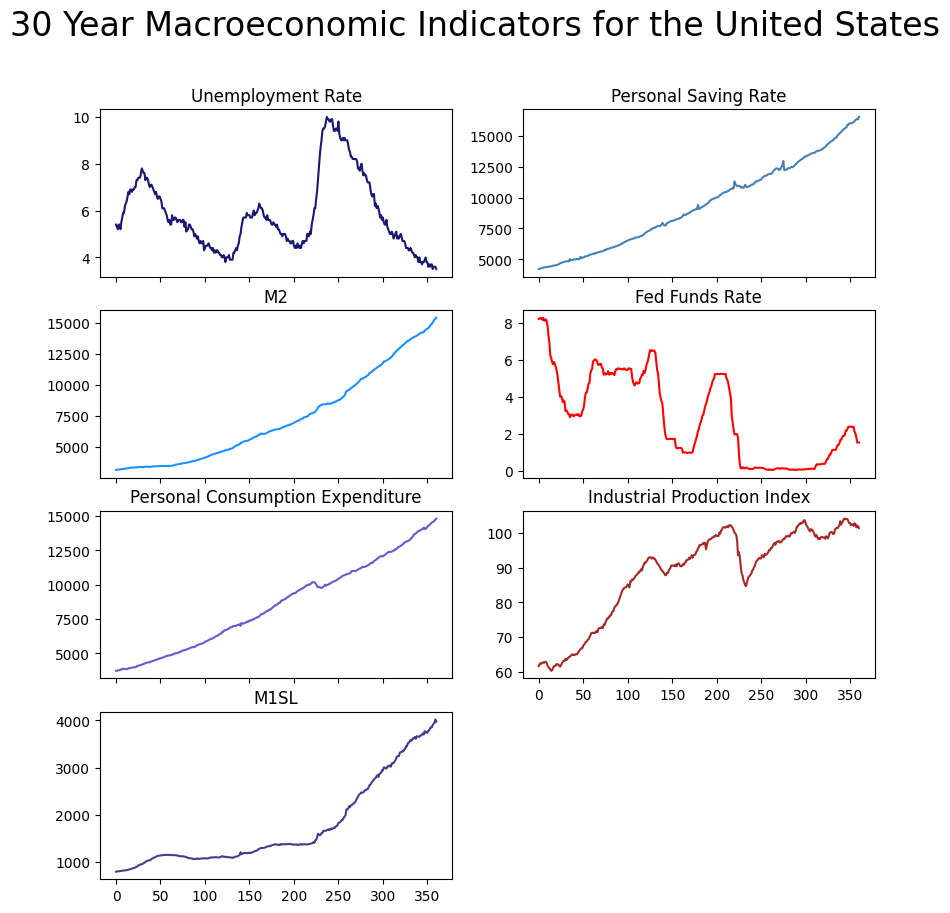

In [17]:
selected_columns = ['UNRATE', 'DSPI', 'M2', 'FEDFUNDS', 'PCE', 'INDPRO', 'M1SL']

inf_data[selected_columns].plot(kind='line',
                                subplots=True,
                                figsize=(10, 10),
                                title=['Unemployment Rate', 'Personal Saving Rate', 'M2', 'Fed Funds Rate',
                                       'Personal Consumption Expenditure', 'Industrial Production Index', 'M1SL'],
                                legend=False,
                                layout=(4, 2),
                                sharex=True,
                                style=['midnightblue', 'steelblue', 'dodgerblue', 'red', 'slateblue', 'brown', 'darkslateblue'])

plt.suptitle('30 Year Macroeconomic Indicators for the United States', fontsize=24)
plt.show()

**Core CPI trend by Month and Quarter**

In [18]:
inf_df['year'] = inf_df['DATE'].apply(lambda x: x.year)
inf_df['quarter'] = inf_df['DATE'].apply(lambda x: x.quarter)
inf_df['month'] = inf_df['DATE'].apply(lambda x: x.month)

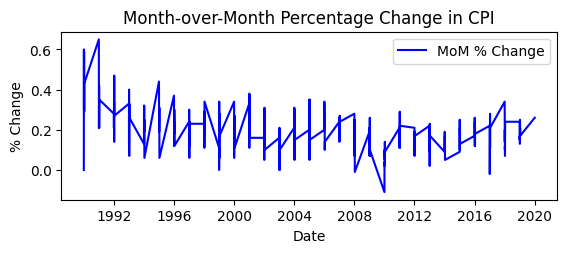

In [35]:
# Line plot for cpi_pct_mom
plt.subplot(2, 1, 1)
plt.plot(inf_data['DATE'], inf_df['cpi_pct_mom'], color='blue', label='MoM % Change')
plt.title('Month-over-Month Percentage Change in CPI')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.legend()


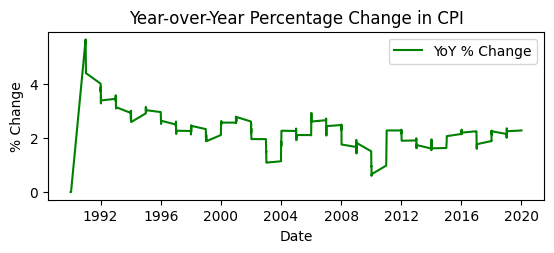

In [36]:
# Line plot for cpi_pct_yoy
plt.subplot(2, 1, 2)
plt.plot(inf_data['DATE'], inf_df['cpi_pct_yoy'], color='green', label='YoY % Change')
plt.title('Year-over-Year Percentage Change in CPI')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.legend()

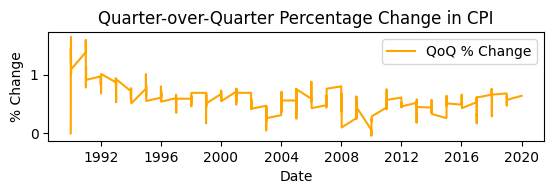

In [37]:
plt.subplot(3, 1, 3)
plt.plot(inf_data['DATE'], inf_df['cpi_pct_qoq'], color='orange', label='QoQ % Change')
plt.title('Quarter-over-Quarter Percentage Change in CPI')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.legend()

In [49]:

inf_data.head(5)

,DATE,CPI,M2,UNRATE,DSPI,PCE,FEDFUNDS,INDPRO,M1SL,cpi_pct_mom,cpi_pct_yoy
0,1990-01-01,132.1,3166.8,5.4,4208.4,3730.7,8.23,61.6440,795.4,0.00,0.0
1,1990-01-02,132.7,3179.2,5.3,4236.3,3728.2,8.24,62.2108,798.1,0.45,0.0
2,1990-01-03,133.5,3190.1,5.2,4254.0,3754.9,8.28,62.5068,801.5,0.60,0.0
3,1990-01-04,134.0,3201.6,5.4,4290.8,3770.0,8.26,62.3597,806.1,0.37,0.0
4,1990-01-05,134.4,3200.6,5.4,4296.0,3775.8,8.18,62.5474,804.2,0.30,0.0


In [50]:
inf_data.shape

(361, 11)

In [57]:
df_cpi = inf_data.set_index('DATE')

In [58]:
df_cpi.head()

,CPI,M2,UNRATE,DSPI,PCE,FEDFUNDS,INDPRO,M1SL,cpi_pct_mom,cpi_pct_yoy
DATE,,,,,,,,,,
1990-01-01,132.1,3166.8,5.4,4208.4,3730.7,8.23,61.6440,795.4,0.00,0.0
1990-01-02,132.7,3179.2,5.3,4236.3,3728.2,8.24,62.2108,798.1,0.45,0.0
1990-01-03,133.5,3190.1,5.2,4254.0,3754.9,8.28,62.5068,801.5,0.60,0.0
1990-01-04,134.0,3201.6,5.4,4290.8,3770.0,8.26,62.3597,806.1,0.37,0.0
1990-01-05,134.4,3200.6,5.4,4296.0,3775.8,8.18,62.5474,804.2,0.30,0.0


**Decompose the data into trend, seasonal and residual components**

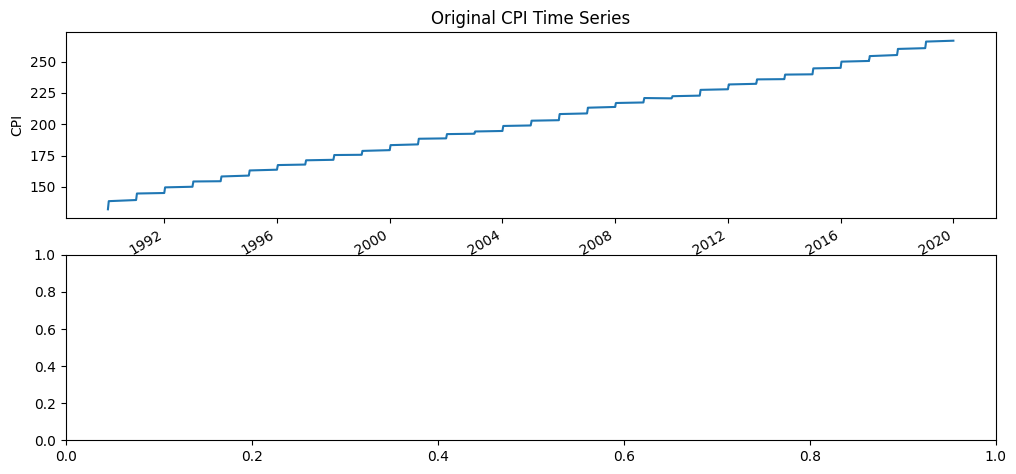

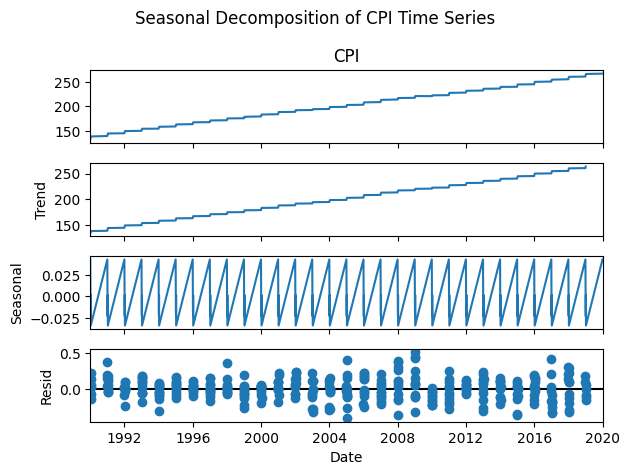

In [60]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose



# Plot original time series
plt.figure(figsize=(12, 6))
plt.subplot(211)
df_cpi['CPI'].plot(title='Original CPI Time Series')
plt.xlabel('Date')
plt.ylabel('CPI')

# Plot seasonal decomposition
plt.subplot(212)
result = seasonal_decompose(df_cpi['CPI'], model='additive', period=12)
result.plot()
plt.suptitle('Seasonal Decomposition of CPI Time Series')
plt.xlabel('Date')

plt.tight_layout()
plt.show()


The data shows a clear upward trend and is not stationary. As one of the key assumptions of the ARIMA model is that the time-series is stationary, we need to correct the non-stationarity later.


**Splitting the Data**

As the dataset is small, we will use the last 12 months as the out of sample test dataset.


Training dataset: 349, Test dataset: 12


<Axes: xlabel='DATE'>

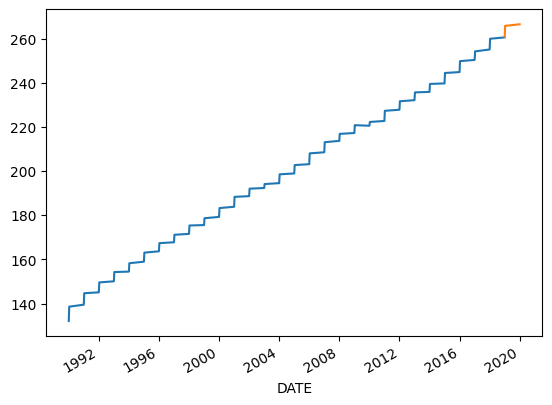

In [61]:
split_point = len(df_cpi) - 12
train, test = df_cpi[0:split_point], df_cpi[split_point:]
print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))
train['CPI'].plot()
test['CPI'].plot()

**Take first differences**

Here, we are finding the number of optimal differencing to remove unit root so that the time-series is stationary. This is done by using diff() function and testing with Augmented Dickey-Fuller test.

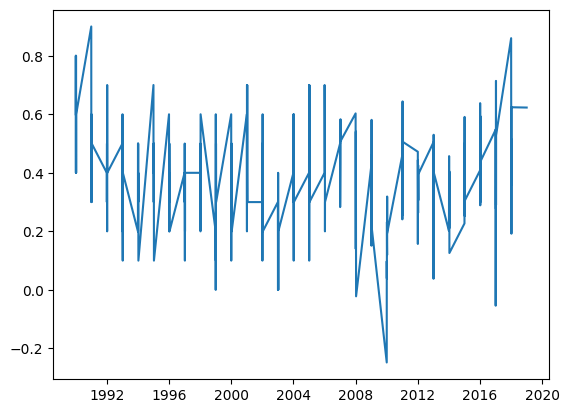

In [62]:
diff = train['CPI'].diff()
plt.plot(diff)
plt.show()
diff = diff.dropna()


Augmented Dickey–Fuller test

With the small p-value, a 1 differencing is enough to remove unit root and make the series stationary.


In [63]:
def adf_test(df):
    result = adfuller(df.values)
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

adf_test(diff)

Series is stationary



Plot ACF and PACF

Now, we need to find the optimal p and q using acf and pacf plot. Where p is the number of lags and q is the order of the MA term.

Finding the order of Auto Regressive Term (p)

    PACF lag 1 is significant



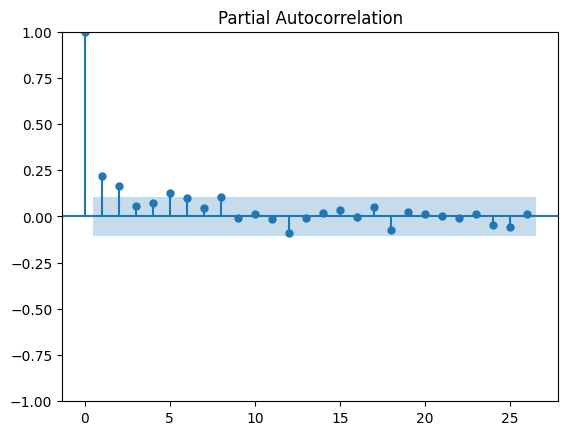

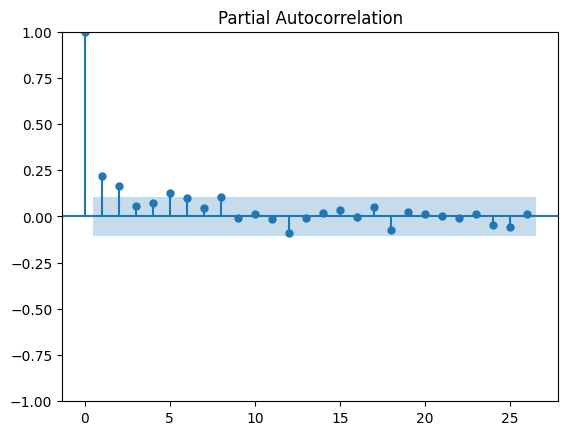

In [64]:
plot_pacf(diff.values)



Finding the order of Moving Average Term (q)

    q = 1 and 2 is significant, try conservative take of q = 1.



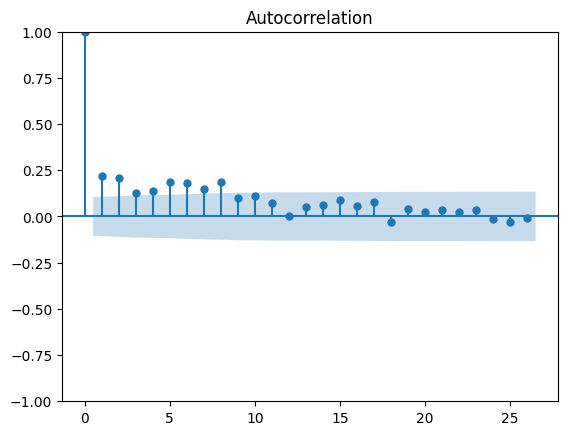

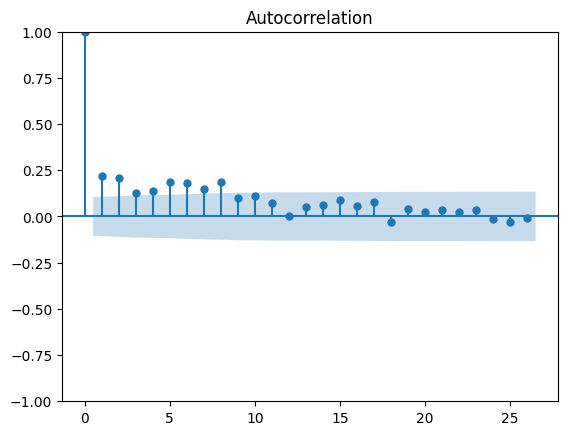

In [65]:
plot_acf(diff.values)

THE LAGS BECOME SIGNIFICANTLY DIFFERENT FROM 0 AT 1, SO THE ORDER OF OUR MODEL IS (1,1,1)

In [81]:
arima_model = ARIMA(np.log(train['CPI']), order = (1,1,1))

arima_fit = arima_model.fit()
arima_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  349
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1957.275
Date:                Mon, 27 Nov 2023   AIC                          -3908.550
Time:                        17:50:26   BIC                          -3896.994
Sample:                             0   HQIC                         -3903.949
                                - 349                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9935      0.005    218.267      0.000       0.985       1.002
ma.L1         -0.6634      0.052    -12.759      0.000      -0.765      -0.562
sigma2      7.545e-07   6.11e-08     12.342      0.000    6.35e-07    8.74e-07
===================================================================================
Ljung-Box (L1) (Q):                   8.19   Jarque-Bera (JB):                 3.22
Prob(Q):                              0.00   Prob(JB):                         0.20
Heteroskedasticity (H):               0.41   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
import pandas as pd

# Assuming 'train' is your DataFrame with a datetime index
future_index = pd.date_range(start=train.index[-1], periods=13, freq='D')[1:]

# Forecast using the future index
forecast = arima_fit.get_forecast(steps=12).predicted_mean
forecast.index = future_index

# Convert back to the original scale (if you had taken the log during modeling)
forecast_original_scale = np.exp(forecast)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



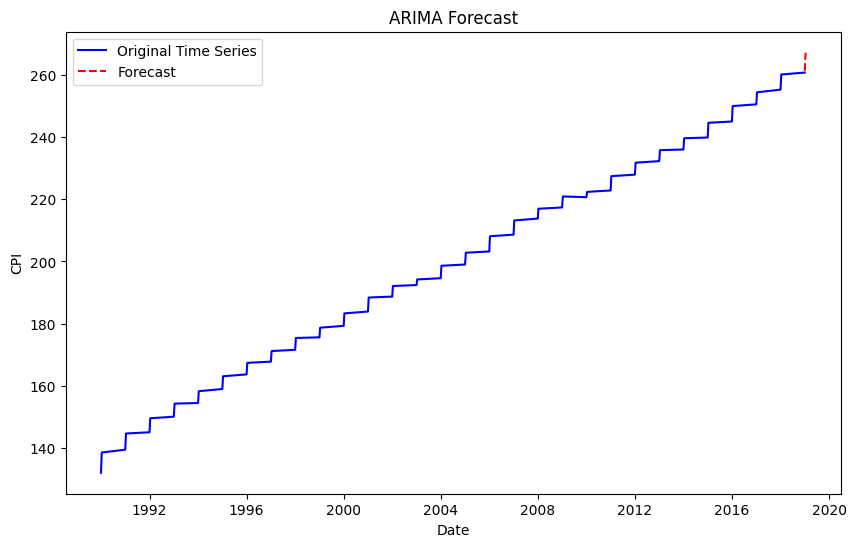

In [83]:


plt.figure(figsize=(10, 6))

# Plotting the original time series
plt.plot(train.index, train['CPI'], label='Original Time Series', color='blue')

# Plotting the forecasted values
plt.plot(forecast_original_scale.index, forecast_original_scale, label='Forecast', linestyle='dashed', color='red')

plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



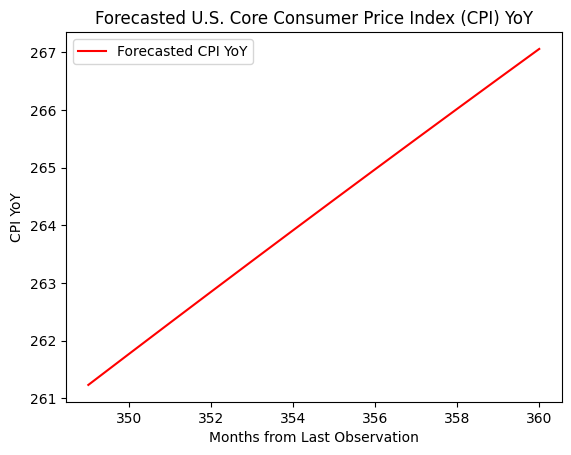

The forecasted U.S. Core Consumer Price Index (CPI) YoY is 2.3 %


In [84]:
import matplotlib.pyplot as plt

# Assuming 'arima_fit' is your ARIMA model and 'df_cpi' is your DataFrame
forecast = arima_fit.forecast(steps=12)
forecast_original_scale = np.exp(forecast)

plt.plot(forecast_original_scale, color='red', label='Forecasted CPI YoY')

# Add labels and legend
plt.title('Forecasted U.S. Core Consumer Price Index (CPI) YoY')
plt.xlabel('Months from Last Observation')
plt.ylabel('CPI YoY')
plt.legend()
plt.show()

# Calculate percentage change
pct_chg = ((forecast_original_scale.iloc[-1] - df_cpi.iloc[-12]['CPI']) / df_cpi.iloc[-12]['CPI']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is', round(pct_chg, 2), '%')


In [85]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df_cpi['CPI'][-12:], forecast_original_scale)
mse = mean_squared_error(df_cpi['CPI'][-12:], forecast_original_scale)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')


MAE: 0.47
MSE: 0.24
RMSE: 0.49


In [87]:
# Assuming 'arima_fit' is your ARIMA model
ar_coefficients = arima_fit.arparams
ma_coefficients = arima_fit.maparams

print("AR Coefficients:", ar_coefficients)
print("MA Coefficients:", ma_coefficients)


AR Coefficients: [0.99351192]
MA Coefficients: [-0.66343627]
